# Mask Capillary Streaks

This notebook explores methods for masking the streaks in the SAXS pattern from the quartz capillary to improve analysis of the scattering signal of the SiO2 nanoparticles in solution in the capillary.

In [3]:
import numpy as np
import os
import glob
import matplotlib.pyplot as plt
from matplotlib.ticker import MultipleLocator
import pandas as pd

from scipy.signal import medfilt2d

import saxs
import saxsplot

from importlib import reload
reload(saxs)
reload(saxsplot)

# parameters
data_folder_path = '..\\..\\..\\EXPERIMENTS\\APS\\NP_0319\\SAXS\\quartzcap\\'
filename_structure = 'quartzcap_hs104_*.tif'
signal_scan = 191
bkgd_scan = 189
air_scan = 187
phi_mask = (-np.pi/3, np.pi/12)
r_lim = (10,400)
# parameters from the header in "processing" folder
pixel_size = 265.8E-6 # [m]
d_detector = 8.5067
center = (130, 510) # (y, x)

## Load Data and Plot without Masking

We will first plot data, just doing background subtraction to remove the effects of the streaking off the quartz capillary walls.

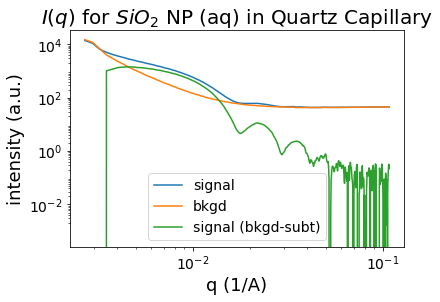

In [4]:
# Get file path
filepath_structure = os.path.join(data_folder_path,filename_structure)
file_list = glob.glob(filepath_structure)

# Average background intensities, averaging over phi
bkgd_file_list = saxs.get_scan_filenames(bkgd_scan, file_list)
bkgd_mean, _, q = saxs.compute_stats(bkgd_file_list, 'phi', r_lim=r_lim, center=center, d_detector=d_detector, 
                                     pixel_size=pixel_size)

# Average background intensities, averaging over q
signal_file_list = saxs.get_scan_filenames(signal_scan, file_list)
signal_mean, _, q = saxs.compute_stats(signal_file_list, 'phi', r_lim=r_lim, center=center,
                                    d_detector=d_detector, pixel_size=pixel_size)

# Set up plot parameters
q_list = [q, q, q]
intensity_list = [signal_mean, bkgd_mean, signal_mean - bkgd_mean]
label_list = ['signal', 'bkgd', 'signal (bkgd-subt)']
# Plot background-subtracted data
ax = saxsplot.plot(q_list, intensity_list, label_list=label_list, title=r'$I(q)$ for $SiO_2$ NP (aq) in Quartz Capillary')
# add minor ticks to axes
digits = np.arange(2,10)
ticks = np.concatenate((digits*1E-3, digits*1E-2, digits*1E-1, digits, digits*1E1, digits*1E2, digits*1E3))
ax.set_yticks(ticks, minor=True)
# save figure
plt.savefig(data_folder_path + 'sio2_h2o_50ppm_quartzcap.pdf', bbox_inches="tight")

However, if we plot as a function of $\phi$, we see that the streaking remains.

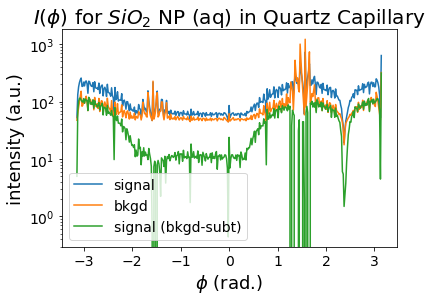

In [5]:
# Average background intensities, averaging over phi
bkgd_mean, _, phi = saxs.compute_stats(bkgd_file_list, 'q', r_lim=r_lim, center=center, d_detector=d_detector, 
                                     pixel_size=pixel_size)

# Average background intensities, averaging over q
signal_mean, _, phi = saxs.compute_stats(signal_file_list, 'q', r_lim=r_lim, center=center,
                                    d_detector=d_detector, pixel_size=pixel_size)

# Set up plot parameters
phi_list = [phi, phi, phi]
intensity_list = [signal_mean, bkgd_mean, signal_mean - bkgd_mean]
label_list = ['signal', 'bkgd', 'signal (bkgd-subt)']
# Plot background-subtracted data
saxsplot.plot(phi_list, intensity_list, label_list=label_list, title=r'$I(\phi)$ for $SiO_2$ NP (aq) in Quartz Capillary',
             xscale='linear', x_label=r'$\phi$ (rad.)')

The intensity fluctuates a lot with $\phi$, even for the background-subtracted signal, so background subtraction might not be sufficient to remove the effects of streaking from the signal.

## Mask Signal along Azimuthal Axis

To solve this problem, we mask angles that include the streaks from the walls of the quartz capillary. We plot the intensity versus $\phi$ to demonstrate that the masked signal is fairly isotropic, as well as the region of interest to show which pixels are considered.

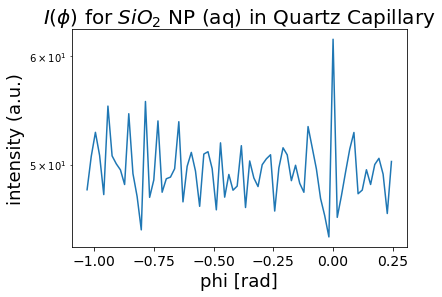

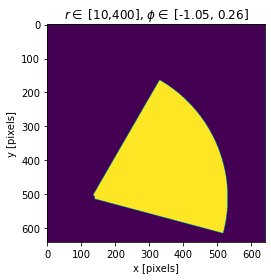

In [6]:
# Average background intensities, averaging over q
bkgd_mean, _, phi = saxs.compute_stats(bkgd_file_list, 'q', phi_lim=phi_mask, r_lim=r_lim, center=center,
                                    d_detector=d_detector, pixel_size=pixel_size)

# Plot background
saxsplot.plot(phi, bkgd_mean, title=r'$I(\phi)$ for $SiO_2$ NP (aq) in Quartz Capillary',
             xscale='linear', x_label='phi [rad]')

# plot region of interest along with sample image
saxsplot.show_roi(plt.imread(bkgd_file_list[0]), center, r_lim, phi_mask)
plt.savefig(data_folder_path + 'masking_roi.pdf')

## Plot Intensity versus Wavenumber

Having identified an azimuthal section that excludes the streaking, we plot the intensity as a function of the wavenumber. We are specifically looking for signature peaks and valleys of monodisperse spheres above the background.

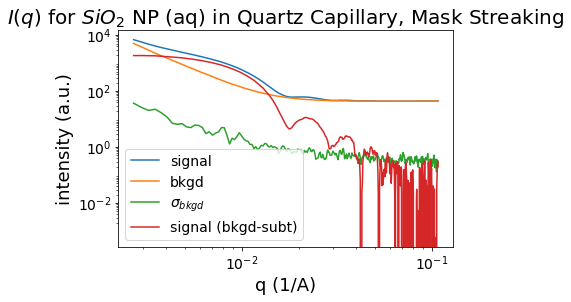

In [7]:
# Average background intensities, averaging over phi
bkgd_mean, bkgd_std, q = saxs.compute_stats(bkgd_file_list, 'phi', phi_lim=phi_mask, r_lim=r_lim, center=center,
                                    d_detector=d_detector, pixel_size=pixel_size)

# Average background intensities, averaging over q
signal_mean, _, q = saxs.compute_stats(signal_file_list, 'phi', phi_lim=phi_mask, r_lim=r_lim, center=center,
                                    d_detector=d_detector, pixel_size=pixel_size)

# Set up plot parameters
q_list = [q, q, q, q]
intensity_list = [signal_mean, bkgd_mean, bkgd_std, signal_mean - bkgd_mean]
label_list = ['signal', 'bkgd', r'$\sigma_{bkgd}$', 'signal (bkgd-subt)']
# Plot background-subtracted data
ax = saxsplot.plot(q_list, intensity_list, label_list=label_list, 
              title=r'$I(q)$ for $SiO_2$ NP (aq) in Quartz Capillary, Mask Streaking')
# add minor ticks to axes
digits = np.arange(2,10)
ticks = np.concatenate((digits*1E-3, digits*1E-2, digits*1E-1, digits, digits*1E1, digits*1E2, digits*1E3))
ax.set_yticks(ticks, minor=True)
# save figure
plt.savefig(data_folder_path + 'sio2_h2o_50ppm_quartzcap_mask_streaking.pdf', bbox_inches="tight")

While masking does not seem to improve the peaks at higher $q$, it has helped extend the plateau to lower $q$, which is crucial for estimating the radius of gyration of the sample. **Therefore, masking improved data quality.**

Compared to the flow cell, the signal above the background is weaker (2000 vs. 4000) and the background is stronger (about 5000 at the plateau vs. about 2000 at the plateau). This will likely raise the detection threshold above the 1 bubble of 50 nm / 10 $\mu$m that was found for the flow cell in `flow_bkgd_characterization.ipynb`.

In this case, at the low-$q$ plateau, the signal has about 2000 and the noise ($\approx \sigma_{bkgd}$) is about 40, so a signal about 50 times lower could be detected (vs. 300 times lower for the flow cell). Thus we could probably only detect down to 1 ppm, which corresponds to about 1 bubble per $3.5 \mu$m (as opposed to 1 bubble per $1 \mu$m at 50 ppm). See `20190402_sio2_np_saxs_summary.ppt` for details on the concentrations tested.

## Save Data

Because the masked data produced a clearer plateau at low $q$, I will save it to a csv file in the format $(q, I)$ for analysis with SASView.

In [8]:
# Save data in Pandas dataframe and convert to csv
df = pd.DataFrame()
df['q (1/A)'] = q
df['I(q) (a.u.)'] = signal_mean - bkgd_mean
df.to_csv(data_folder_path + 'q_I_mask_streaking.csv', index=False, header=False)